# 量子近似优化算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_quantum_approximate_optimization_algorithm.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_quantum_approximate_optimization_algorithm.py)&emsp;
[![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/quantum_approximate_optimization_algorithm.ipynb)

## 概述

量子近似优化算法（Quantum Approximate Optimization Algorithm，QAOA）是利用量子计算机来近似解决组合优化问题的量子算法，最早由Farhi等人于2014年提出。在本文档里，我们将利用QAOA算法来解决最大割问题（Max-Cut），来熟悉MindSpore Quantum中量子线路的搭建和训练。

## 环境准备

本文档所需要的额外库：

- networkx

> `networkx`是创建、操作和研究复杂网络的结构、动态和功能库。可通过如下代码来进行安装。

```bash
pip3 install networkx
```

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/x86_64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [3]:
%%capture captured_output
# 安装 mindquantum, networkx
!pip install mindquantum==0.9.0 -i https://repo.huaweicloud.com/repository/pypi/simple/
!pip install networkx -i https://repo.huaweicloud.com/repository/pypi/simple/

## Max-Cut问题描述

Max-Cut问题是图论中的一个NP-complete问题，它需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图（a），一个图由五个顶点构成，相互连接的边为```(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (0, 4)```。为了使得被切割的边最多，我们尝试通过（b）图的分割，将1、2、4分为一组，0、3分成另一组，因此可得到被切割的边有5条。后面我们将用穷举法验证这个解是否正确。当图中顶点较少时，我们可以在较短时间内通过穷举法找到最大的切割边数，但当图中顶点增多时，我们很难找到有效的经典算法来解决Max-Cut问题，因为这类NP-complete问题很有可能不存在多项式时间算法。但尽管精确解不容易得到，我们却可以想办法在多项式时间内找到问题的一个近似解，这就是近似优化算法。下面，我们介绍怎么将Max-Cut问题转化为一个哈密顿量的基态能量求解问题。

![max cut](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/Max_Cut.png)

## Max-Cut问题量子化

这里我们将图中的每个顶点赋予一个量子比特，当顶点被分到左边时，我们将该顶点上的量子比特设置为$\left|0\right>$态，同理，右边为$\left|1\right>$态，当两个顶点被分到不同的集合中时，这两个顶点上的比特将处于不同的量子态。例如对于第0个顶点和第1个顶点，当其连线被切割时，两个顶点上的比特对应的量子态可以表示为$|01\rangle$（顶点1：左，顶点0：右）或$|10\rangle$（顶点1：右，顶点0：左）；若它们被分到同一边，则对应量子态为$|00\rangle$或$|11\rangle$。因此我们只要找到一个哈密顿量$H$使得：当有连线的两个顶点处于不同量子态时，哈密顿量的期望值为-1，即

$$
\langle 01|H|01\rangle=-1,\quad \langle 10|H|10\rangle=-1
$$

而当有连线的顶点处于相同量子态时，哈密顿量的期望值为0，即

$$
\langle 00|H|00\rangle=0,\quad \langle 11|H|11\rangle=0
$$

随后只要使哈密顿量的期望值最小化，就可以找到最大切割边数，以及此时对应的分组情况。之所以将不同量子态时的期望值设为-1，是因为在量子神经网络的训练中，Ansatz中的参数的梯度会一直下降，同时测量值也会一直减少，该训练方法就是以找到最小值为目标，这里我们用它来寻找哈密顿量的基态能量。此时，我们选择哈密顿量$H=(Z_1Z_0-1)/2$，这里$Z$为泡利$Z$算符。此时有：

$$
Z_1Z_0|00\rangle=|00\rangle,\quad Z_1Z_0|11\rangle=|11\rangle, \quad Z_1Z_0|01\rangle=-|01\rangle, \quad Z_1Z_0|10\rangle=-|10\rangle
$$

因此当顶点被分到不同集合时：

$$
\left<01\right|H\left|01\right>=\frac{1}{2}\left<01\right|Z_1Z_0\left|01\right>-\frac{1}{2}=-1
$$

$$
\left<10\right|H\left|10\right>=\frac{1}{2}\left<10\right|Z_1Z_0\left|10\right>-\frac{1}{2}=-1
$$

而当顶点被分到同一集合中时，不难验证此时：

$$
\left<00\right|H\left|00\right>=\frac{1}{2}\left<00\right|Z_1Z_0\left|00\right>-\frac{1}{2}=0
$$

$$
\left<11\right|H\left|11\right>=\frac{1}{2}\left<11\right|Z_1Z_0\left|11\right>-\frac{1}{2}=0
$$

因此，我们只要对图中的每条边写出上述哈密顿量，然后将所有边求和，即可写出图对应的哈密顿量$H$，利用量子计算机求得$H$的基态能量与基态，我们就可以得到该图的Max-Cut切割方案与最大切割边数。我们记所有边的集合为$C$，所有边条数为$c$，则哈密顿量可写为：

$$
H=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

## 导入相关依赖

In [4]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, Rzz, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

/home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Disable mqvector gpu backend due to: Malloc GPU memory failed: cudaErrorInsufficientDriver, CUDA driver version is insufficient for CUDA runtime version
  from .available_simulator import SUPPORTED_SIMULATOR


## 搭建所需求解的图

通过`add_path`可在图中添加边。最后画出图的结构。

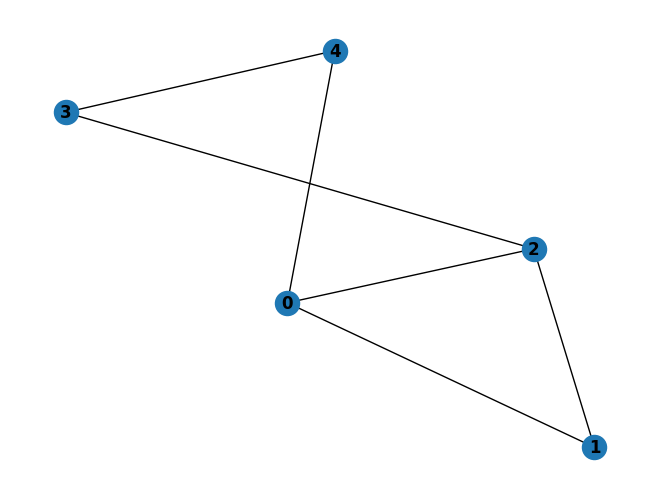

In [5]:
graph = nx.Graph()
nx.add_path(graph, [0, 1])
nx.add_path(graph, [1, 2])
nx.add_path(graph, [2, 3])
nx.add_path(graph, [3, 4])
nx.add_path(graph, [0, 4])
nx.add_path(graph, [0, 2])
nx.draw(graph, with_labels=True, font_weight='bold')

如上图，我们得到一个由5个节点和6条边构成的图结构。

接下来我们用穷举法来看看所有情况的切割边数。

In [6]:
for i in graph.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(graph, [i]))            # 一组1个节点、另一组4个节点的所有情况
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(graph, [i, j]))  # 一组2个节点、另一组3个节点的所有情况

one size: [0] cut= 3
one size: [1] cut= 2
one size: [1, 0] cut= 3
one size: [2] cut= 3
one size: [2, 0] cut= 4
one size: [2, 1] cut= 3
one size: [3] cut= 2
one size: [3, 0] cut= 5
one size: [3, 1] cut= 4
one size: [3, 2] cut= 3
one size: [4] cut= 2
one size: [4, 0] cut= 3
one size: [4, 1] cut= 4
one size: [4, 2] cut= 5
one size: [4, 3] cut= 2


从以上结果可以看出，穷举法得到的最大切割边数为5，如果对节点分组的左右进行区分，则一共有4种分组方法可以使切割边数最大，即该问题有4个简并解。

## QAOA算法整体流程

1. 搭建QAOA量子线路，其中ansatz线路包含可以训练的参数
2. 初始化线路中的参数
3. 运行该量子线路，得到量子态$|\psi\rangle$
4. 计算目标哈密顿量$H_C$的期望值$\langle\psi|H_C|\psi\rangle$
5. 根据第4步的结果，使用Adam优化器优化线路中参数
6. 重复3-5步，直到第4步结果基本不再变化
7. 根据第4步的结果，算出目标问题的近似解

在该流程中，第2-6步都可以由MindSpore和MindSpore Quantum中现成的包和函数来实现，因此我们将重点关注第1步——量子线路的搭建。

![Flowchart](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/QAOA_Flowchart.png)

## 搭建QAOA量子线路

先前提到，我们需要将问题对应的哈密顿量

$$
H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

最小化来找到问题的解，也就是说我们要找到该哈密顿量的基态。对此我们可以采用量子绝热演化的方法，使系统先处于某一简单哈密顿量$H_B$的基态上，然后使简单的哈密顿量$H_B$绝热地、缓慢地演化至某一复杂的哈密顿量$H_C$，根据绝热定理，系统将始终保持在哈密顿量的基态上，最终达到复杂哈密顿量$H_C$的基态。

我们将要搭建的量子线路就是采用以上思路，选取初始简单哈密顿量为

$$
H_B=\sum_i -X_i
$$

并将量子线路制备到$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$，这里通过对所有量子比特作用[Hadamard门](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html)即可实现。然后连接ansatz含参线路，通过不断地优化其中参数可以使得ansatz线路越来越接近真实绝热演化的效果，最终得到的量子线路可以视为模拟近似了一个真实的绝热演化过程。

### ansatz线路

在量子绝热演化中，首先选取初始哈密顿量

$$
H_B=\sum_i -X_i
$$

并使系统处于$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$。然后缓慢地作用如下含时哈密顿量

$$
H(t)=(1-\frac{t}{T})H_B+(\frac{t}{T})H_C
$$

注意到当$t=T$时，$H(T)=H_C$。当选取的$T$足够大时（满足绝热条件），系统将始终处于$H(t)$的瞬时基态上，此时系统的量子态将从初始哈密顿量$H_B$的基态$|\psi (0)\rangle$绝热地演化到目标哈密顿量$H_C$的基态$|\psi (T)\rangle$上，即

$$
|\psi (T)\rangle=\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}|\psi(0)\rangle
$$

也就是说，ansatz线路需要模拟的就是$\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}$这一演化过程。接下来我们将对这个式子进行一些近似和化简，使其变为可以在量子线路中实现的形式。

考虑如下trotter公式

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}=\lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH(t_l)\Delta t},\quad \Delta t=\frac{T}{N},\quad t_l=l\Delta t
$$

略去$O(\Delta t^2)$项，得到

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}\approx \lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH_B(1-t_l/T)\Delta t}e^{-iH_C t_l\Delta t/T}
$$

令$\beta_l=(1-t_l/T)\Delta t$，$\gamma_l=t_l\Delta t/T$，并取$N$为一个有限大的整数，即得到QAOA的ansatz

$$
|\psi(\gamma,\beta)\rangle=\prod^p_{l=1}e^{-i\beta_l H_B}e^{-i\gamma_l H_C}|\psi_{in}\rangle
$$

因此我们需要搭建的ansatz线路由$U_C(\gamma)$和$U_B(\beta)$这两个酉变换交替构成，其中$U_C(\gamma)=e^{-i\frac{\gamma}{2} \sum_{\langle i,j\rangle}Z_i Z_j}$可以由 [Rzz](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.Rzz.html) 门实现，$U_B(\beta)=e^{i\beta \sum_i X_i}$则相当于在每个量子比特上作用一个 [RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html)旋转门，$\gamma$和$\beta$是可训练的参数。

搭建$U_C(\gamma)$对应的量子线路：

In [7]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += Rzz(para).on(i)        # 对图中的每条边作用Rzz门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

线路展示：

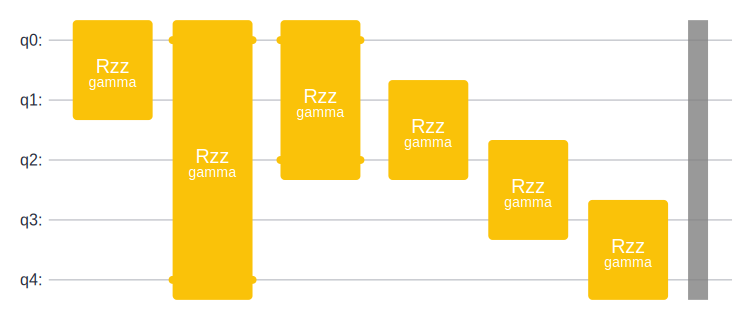

In [8]:
# pylint: disable=W0104
circuit = build_hc(graph, 'gamma')
circuit.svg()

搭建$U_B(\beta)$对应的量子线路：

In [9]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

线路展示：

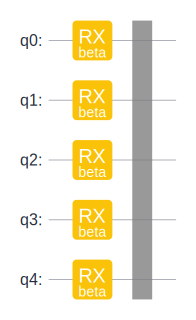

In [10]:
# pylint: disable=W0104
circuit = build_hb(graph, 'beta')
circuit.svg()

实现了一层酉变换$U_B(\beta) U_C(\gamma)$的ansatz线路如下所示：

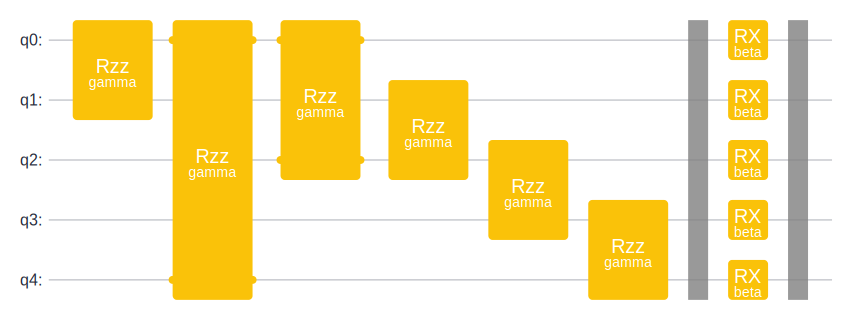

In [11]:
# pylint: disable=W0104
circuit = build_hc(graph, 'gamma') + build_hb(graph, 'beta')
circuit.svg()

为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：

In [12]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

构建图对应的哈密顿量$H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$（忽略常数项和系数）：

In [13]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成HC哈密顿量
    return ham

### 生成完整的量子线路和图所对应的哈密顿量

这里我们选择`p = 4`，表示选用4层的QAOA量子线路，`ansatz`是求解该问题的量子线路，`init_state_circ`是将量子态制备到均匀叠加态（$H_B$的基态）上的量子线路。

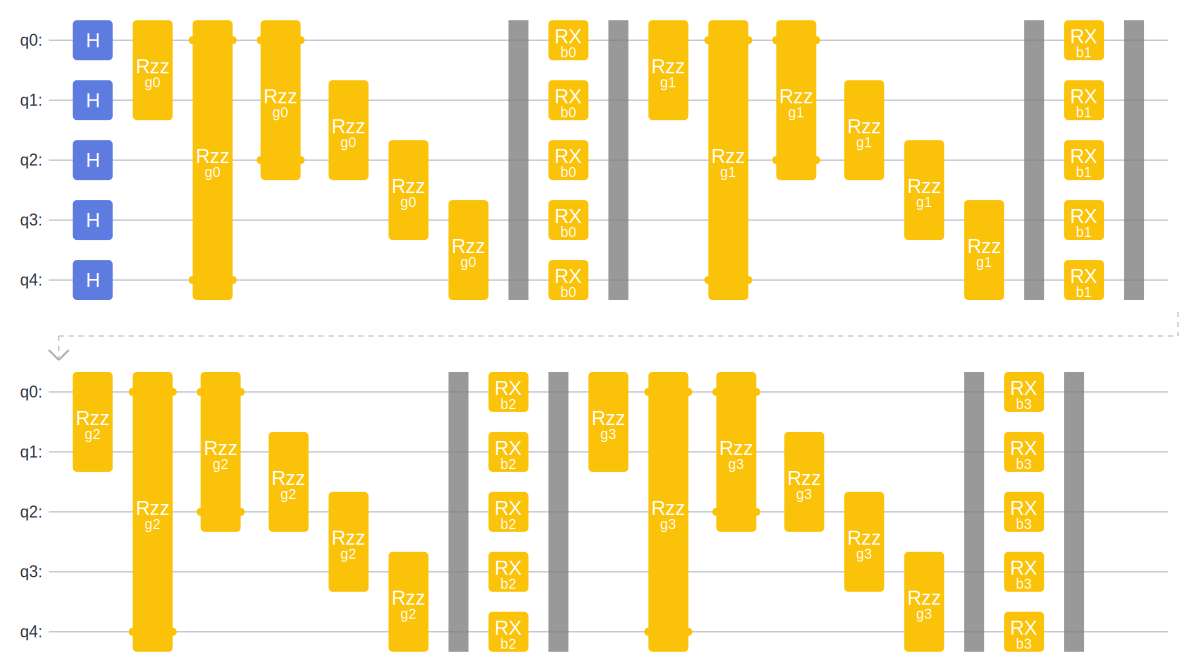

In [14]:
# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(graph))              # 生成哈密顿量
init_state_circ = UN(H, graph.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(graph, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz                  # 将初始化线路与ansatz线路组合成一个线路
circ.svg(width=1200)

## 方法一：利用传统优化算法完成优化搜索

### 生成梯度算子

首先，我们利用模拟器生成计算QAOA变分量子线路期望值和梯度的运算算子。

In [15]:
sim = Simulator('mqvector', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)

`grad_ops`是一个可以用来计算期望值和期望值关于变分参数的导数的算子，例如我们可以通过如下方式计算线路在参数为 `p0` 时的期望值和导数。

In [16]:
import numpy as np

rng = np.random.default_rng(10)
p0 = rng.random(size=len(circ.params_name)) * np.pi * 2 - np.pi
f, g = grad_ops(p0)
print('Expectation Value: ', f)
print('Expectation Value Shape: ', f.shape)
print('Gradient: ', g)
print('Gradient Shape: ', g.shape)

Expectation Value:  [[2.2839928+4.88195544e-17j]]
Expectation Value Shape:  (1, 1)
Gradient:  [[[ 0.60966156+0.j -0.50977303+0.j  1.96920626+0.j -1.89443604+0.j
    0.9840882 +0.j -1.85238736+0.j  1.27387126+0.j -0.03135037+0.j]]]
Gradient Shape:  (1, 1, 8)


这里，我们算出来期望值是一个$(m=1, n=1)$维的数组，其中 $m$ 表示本次运算将多少数据通过编码器编码成了量子态，由于QAOA任务不用编码器，因此$m$取默认值1，$n$ 表示本次运算计算了多少个哈密顿量期望值（MindQuantum支持多哈密顿量并行处理），此处我们只计算了`ham`的期望值，所以$n=1$。同理，对于梯度值来说，它的维度是$(m=1,n=1,k=8)$，新增的维度$k=8$表示整个线路中的ansatz变分参数个数。

我们引入`scipy`中的二阶优化器`BFGS`来对Max-Cut问题进行优化，为此首先定义待优化函数：

In [17]:
# pylint: disable=W0604
global step
step = 0

def fun(p, grad_ops):
    global step
    f, g = grad_ops(p)
    f = np.real(f)[0, 0]
    g = np.real(g)[0, 0]
    step += 1
    if step % 10 == 0:
        print(f"train step: {step} , cut: [{(len(graph.edges) - f) / 2}]")
    return f, g

fun(p0, grad_ops)

(2.2839927952206174,
 array([ 0.60966156, -0.50977303,  1.96920626, -1.89443604,  0.9840882 ,
        -1.85238736,  1.27387126, -0.03135037]))

### 训练过程

`BFGS`是一个二阶优化器，效果较好。指定`jac=True`，表示告诉优化器，待优化的函数在返回函数值的同时也会返回梯度值。如设定为`False`，优化器会利用差分法自行计算近似梯度，这会消耗大量算力。

In [18]:
from scipy.optimize import minimize

step = 0
res = minimize(fun, p0, args=(grad_ops, ), method='bfgs', jac=True)

train step: 10 , cut: [3.51031766444423]
train step: 20 , cut: [3.86869597246932]
train step: 30 , cut: [4.194720830468494]
train step: 40 , cut: [4.64910985647362]
train step: 50 , cut: [4.752059940432887]
train step: 60 , cut: [4.77765630429092]
train step: 70 , cut: [4.820166853176863]
train step: 80 , cut: [4.825019602250569]
train step: 90 , cut: [4.826176814773277]


在最优解时，训练得到的变分参数为：

In [19]:
print(dict(zip(circ.params_name, res.x)))

{'g0': -0.7937405249177704, 'b0': 0.24377670096995407, 'g1': 1.6118673532108145, 'b1': -2.090843525880127, 'g2': -0.2191999657174329, 'b2': -1.9553080941053047, 'g3': 1.2663769840189145, 'b3': 2.7528926560153364}


## 方法二：利用 MindSpore 机器学习框架完成量子神经网络训练

### 搭建待训练量子神经网络

由于该问题不需要编码层量子线路，我们这里使用[MQAnsatzOnlyLayer](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/framework/layer/mindquantum.framework.MQAnsatzOnlyLayer.html)作为待训练的量子神经网络，并采用[Adam](https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.Adam.html#mindspore.nn.Adam)优化器。

In [20]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE)
ms.set_device("CPU")

sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

### 训练并展示结果

In [21]:
for i in range(200):
    cut = (len(graph.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i % 10 == 0:
        print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数

train step: 0 , cut: [2.997289]
train step: 10 , cut: [4.2581325]
train step: 20 , cut: [4.629969]
train step: 30 , cut: [4.7770863]
train step: 40 , cut: [4.835993]
train step: 50 , cut: [4.8579903]
train step: 60 , cut: [4.8751945]
train step: 70 , cut: [4.897261]
train step: 80 , cut: [4.922606]
train step: 90 , cut: [4.9370775]
train step: 100 , cut: [4.9382353]
train step: 110 , cut: [4.938509]
train step: 120 , cut: [4.939187]
train step: 130 , cut: [4.9391813]
train step: 140 , cut: [4.939236]
train step: 150 , cut: [4.9392495]
train step: 160 , cut: [4.9392548]
train step: 170 , cut: [4.9392567]
train step: 180 , cut: [4.9392567]
train step: 190 , cut: [4.939257]


根据上面的训练结果我们发现，该问题哈密顿量的基态能量对应的边切割数趋近于5。

### 最优参数

前面我们通过训练得到了量子线路中参数的最优值，下面，我们将最优参数提取出来并存储为字典类型，与之前线路中命名的参数一一对应。

In [22]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)

{'g0': 0.4490316, 'b0': -1.1390557, 'g1': 0.90638006, 'b1': -0.9446744, 'g2': 1.0676569, 'b2': -0.6775476, 'g3': 1.1679369, 'b3': -0.3823743}


### 概率图

我们将最优参数代入量子线路，通过对量子线路进行1000次采样，画出最终量子态在计算基矢下的概率分布：

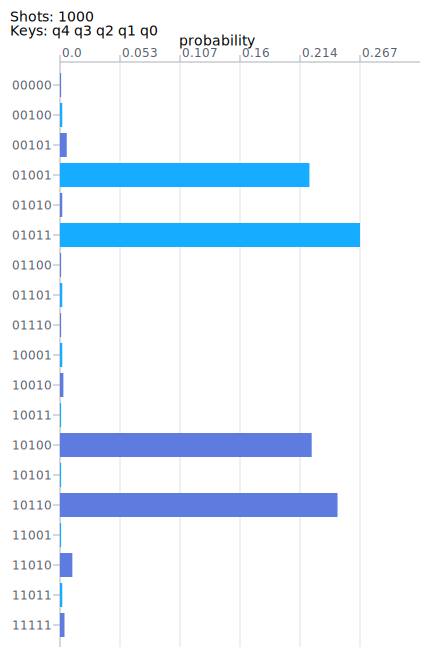

In [23]:
# pylint: disable=W0104
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果

根据概率分布图我们发现，该Max-Cut问题具有四个简并解，每个解对应的概率大概为25%。

- `01001`：编号为1、2、4的顶点在左边，编号为0、3的顶点在右边。
- `10110`：编号为0、3的顶点在左边，编号为1、2、4的顶点在右边。
- `01011`：编号为2、4的顶点在左边，编号为0、1、3的顶点在右边。
- `10100`：编号为0、1、3的顶点在左边，编号为2、4的顶点在右边。

可以发现，以上结果与先前通过穷举法得到的结果相符。

## 总结

这里我们通过量子近似优化算法来解决了Max-Cut问题，并得到了案例中的图对应的最大切割方案。

In [24]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.0
scipy,1.13.1
numpy,1.26.4
System,Info
Python,3.9.20
OS,Linux x86_64
Memory,19.01 GB
CPU Max Thread,9
Date,Fri Feb 21 13:45:42 2025


## 参考文献

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)